In [2]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample


from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')

Create data frame of annotation info

In [4]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 13)
Int64Index([], dtype='int64')
(1084, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,533,5,low slug,46305.0,32714.904,0.368722,39977.724643,9966.541464,2.313672,9.578221,0.000271,37978.838411
1,1,533,5,low slug,149692.5,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
2,2,533,5,low slug,243157.5,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566
3,3,533,5,low slug,243270.0,63014.450,0.232295,32242.081971,21947.090189,5.325133,33.372614,-0.000671,30629.977872
4,4,533,5,low multi,295560.0,74933.164,0.206291,17095.059221,11740.918797,5.372725,34.224633,-0.001093,16240.306260


In [5]:
annot_features_full = annot_features_full[annot_features_full['Annotation'] != 'noise']

In [6]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             Animal                                                            Group                                              time_stamp                                                                                     power_sum                                                                                             spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                         spec_skew                                                                       spec_kurt                                                                              spec_slope                                                                       spec_roll                              \
                count        mean         std   min     25%    50%     75%    max  count        mean        std    min    25%    50%    75%    max  count      mean       std  min  25%  50%  75%  max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min           25%          50%          75%        max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count           mean            std           min            25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std        min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean           std   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
bbc              16.0   81.875000   26.181100  21.0   76.25   84.5  101.75  107.0   16.0  551.125000   8.724487  534.0  543.0  554.0  559.0  559.0   16.0  4.437500  0.512348  4.0  4.0  4.0  5.0  5.0       16.0  222723.281250  161859.049561  13590.0  117303.750  196908.75  301685.625  535702.5      16.0  204078.307625  193322.116804  65204.582  118303.71000  157959.0050  179809.2375   872012.6     16.0  0.101816  0.046395  0.026119  0.085418  0.089934  0.118413  0.219365      16.0  31369.661776   3408.032166  25428.290261  29530.387395  31273.059220  33965.217581  36864.114756        16.0  154295.504440   45887.605222  82643.398891  124006.380527  157006.199597  171826.955013  272975.403907      16.0  4.301428  0.821950  3.272398  3.639845  4.074513  4.857638  5.614859      16.0  19.744209   8.720991  10.020710  12.778336  17.275809  25.393034  34.627316       16.0 -0.002649  0.000134 -0.002793 -0.002730 -0.002686 -0.002620 -0.002319      16.0  29801.178687   3237.630558   
high multi        5.0   60.800000   34.981424  10.0   53.00

In [7]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_full, test_size=0.3, random_state=1, stratify = annot_features_full.Annotation)

In [25]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

rand_noise    630
low slug      362
bbc           107
low multi      98
high slug      35
high multi     28
Name: Annotation, dtype: int64


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
89,89,554,4,low multi,455805.0,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517
28,28,535,5,low multi,22927.5,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713
67,67,542,4,low slug,378922.5,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470
96,96,555,4,low slug,260842.5,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
56,56,535,5,high multi,442462.5,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329


In [9]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up = annot_labels_up.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'noise': 0, 'rand_noise': 0})

In [10]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
89,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517
28,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713
67,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470
96,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
56,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329


In [11]:
group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

In [12]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [13]:
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=10, random_state=0)
svm_cv = SVC(probability=True) 

In [14]:
y_pred_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(annot_labels_up, y_pred_lr)
conf_mat_lr

array([[469, 161],
       [136, 494]], dtype=int64)

In [15]:
y_pred_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(annot_labels_up, y_pred_rf)
conf_mat_rf

array([[606,  24],
       [242, 388]], dtype=int64)

In [16]:
y_pred_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(annot_labels_up, y_pred_svm)
conf_mat_svm

array([[536,  94],
       [128, 502]], dtype=int64)

In [17]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_lr))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_lr))

Sensitivity/Recall (TPR):  0.7841269841269841
Precision (PPV):  0.7541984732824427
Accuracy:  0.7642857142857142
F1: 0.7688715953307393


In [18]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_rf))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_rf))

Sensitivity/Recall (TPR):  0.6158730158730159
Precision (PPV):  0.941747572815534
Accuracy:  0.7888888888888889
F1: 0.744721689059501


In [19]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_svm))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_svm))

Sensitivity/Recall (TPR):  0.7968253968253968
Precision (PPV):  0.8422818791946308
Accuracy:  0.8238095238095238
F1: 0.8189233278955954


In [20]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.8364550264550265
Random forest ROC_AUC:  0.9090388007054674
SVM ROC_AUC:  0.9218039808515999


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

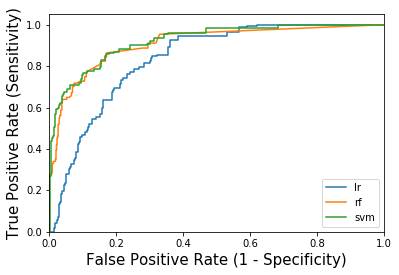

In [21]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(annot_labels_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(annot_labels_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

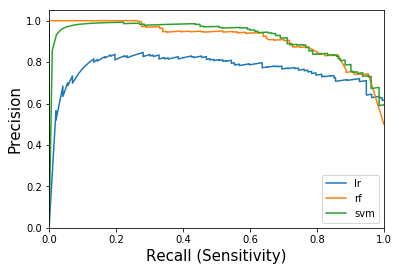

In [22]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

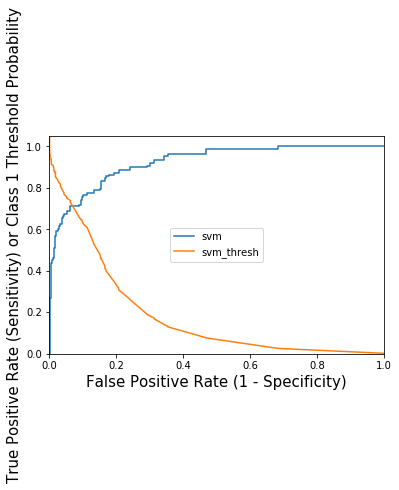

In [23]:
# plot LR and RF model ROC curves
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_svm, thresholds_svm, label="svm_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [26]:
train_orig_upsamples['pred_lr'] = y_pred_prob_lr[:,1]
train_orig_upsamples['pred_rf'] = y_pred_prob_rf[:,1]
train_orig_upsamples['pred_svm'] = y_pred_prob_svm[:,1]
train_orig_upsamples['class_actual'] = annot_labels_up
train_orig_upsamples['class_svm'] = y_pred_svm
train_orig_upsamples.head()

,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf,pred_svm,class_actual,class_svm
89,89,554,4,low multi,455805.0,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517,0.763563,0.793550,0.991499,1,1
28,28,535,5,low multi,22927.5,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713,0.756353,0.663796,0.993715,1,1
67,67,542,4,low slug,378922.5,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470,0.315506,0.000000,0.529880,1,1
96,96,555,4,low slug,260842.5,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800,0.787235,0.090323,0.920960,1,1
56,56,535,5,high multi,442462.5,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329,0.617147,0.987273,0.977044,1,1


In [27]:
train_orig_upsamples.groupby('Annotation')['pred_lr', 'pred_rf', 'pred_svm'].describe()

pred_lr                                                                       pred_rf                                                                       pred_svm                                                                      
             count      mean       std       min       25%       50%       75%       max   count      mean       std       min       25%       50%       75%       max    count      mean       std       min       25%       50%       75%       max
Annotation                                                                                                                                                                                                                                           
bbc          107.0  0.789800  0.100548  0.595083  0.764301  0.801021  0.864593  0.931659   107.0  0.807403  0.216995  0.394512  0.589864  0.890783  0.989773  0.996083    107.0  0.900117  0.115376  0.606264  0.793848  0.967696  0.975716  0.990360
high multi    28.0  0.514759  0.124671  0.341825  0.341825  0.545618  0.617147  0.623851    28.0  0.384343  0.373064  0.100000  0.100000  0.100000  0.540654  0.987273     28.0  0.600167  0.426999  0.024759  0.024759  0.626835  0.977044  0.996920
high slug     35.0  0.587252  0.159388  0.187807  0.523594  0.661120  0.666424  0.741221    35.0  0.400164  0.281899  0.000000  0.195833  0.600000  0.600000  0.740188     35.0  0.517959  0.302115  0.187658  0.261292  0.344657  0.769722  0.969825
low multi     98.0  0.712890  0.103243  0.479079  0.628706  0.759221  0.787941  0.821989    98.0  0.590411  0.319336  0.046667  0.190323  0.663796  0.880808  0.991882     98.0  0.837197  0.220040  0.307127  0.870977  0.946972  0.991499  0.995431
low slug     362.0  0.627144  0.218770  0.200557  0.432595  0.710366  0.816573  0.906622   362.0  0.521559  0.312851  0.000000  0.205758  0.587223  0.757088  0.985464    362.0  0.717960  0.283741  0.075728  0.529880  0.869019  0.926084  0.970803
rand_noise   630.0  0.326180  0.259053  0.009650  0.126859  0.240929  0.513857  0.996192   630.0  0.081176  0.168448  0.000000  0.000000  0.000000  0.100000  0.878477    630.0  0.183728  0.245185  0.001121  0.019433  0.063674  0.245270  0.999994

In [28]:
preds = []
for index, row in train_orig_upsamples.iterrows():
    if (row['class_actual'] == 0) & (row['class_svm'] == 0):
        pred = 'TN'
    if (row['class_actual'] == 0) & (row['class_svm'] == 1):
        pred = 'FP'
    if (row['class_actual'] == 1) & (row['class_svm'] == 1):
        pred = 'TP'
    if (row['class_actual'] == 1) & (row['class_svm'] == 0):
        pred = 'FN'
    preds.append(pred)
    
train_orig_upsamples['pred'] = preds

In [29]:
train_orig_upsamples.groupby('pred').describe()

Unnamed: 0                                                            Animal                                                            Group                                              time_stamp                                                                                     power_sum                                                                                              spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                    spec_skew                                                                       spec_kurt                                                                             spec_slope                                                                       spec_roll                                           \
          count        mean         std  min     25%    50%     75%    max  count        mean        std    min    25%    50%    75%    max  count      mean       std  min  25%  50%  75%  max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min          25%          50%           75%         max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count          mean           std          min           25%           50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std       min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean          std           min   
pred                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
FN        128.0   44.421875   30.050773  0.0   23.00   44.0   60.00   91.0  128.0  539.882812   8.394431  533.0  535.0  535.0  542.0  554.0  128.0  4.648438  0.479334  4.0  4.0  5.0  5.0  5.0      128.0  224022.304688  164517.589929     90.0   36382.500  261585.00  356214.375  567112.5     128.0  141661.868555  339797.473558  29249.727  34755.10350   43037.4650   48098.29325  1366219.00    128.0  0.294856  0.100091  0.027210  0.290657  0.306856  0.366069  0.405450     128.0  35700.658843  10063.993615  16554.420771  31743.227671  35125.159230  41093.574523  55862.628293       128.0  48782.010841  93099.574100  6141.207185   9399.392445  11948.134503   28075.875755  338791.203147     128.0  3.832309  1.484700  2.013338  2.801140  3.493177  4.308415  7.272298     128.0  20.503712  13.580603  3.485998  11.508558  16.746213  22.308306  54.994959      128.0 -0.000134  0.000975 -0.002002 -0.000368 -0.000229  0.000271  0.002021     128.0  33915.625900  9560.793934  15726.699732   
FP         94.0  390.978723  288.890238  3.0  114

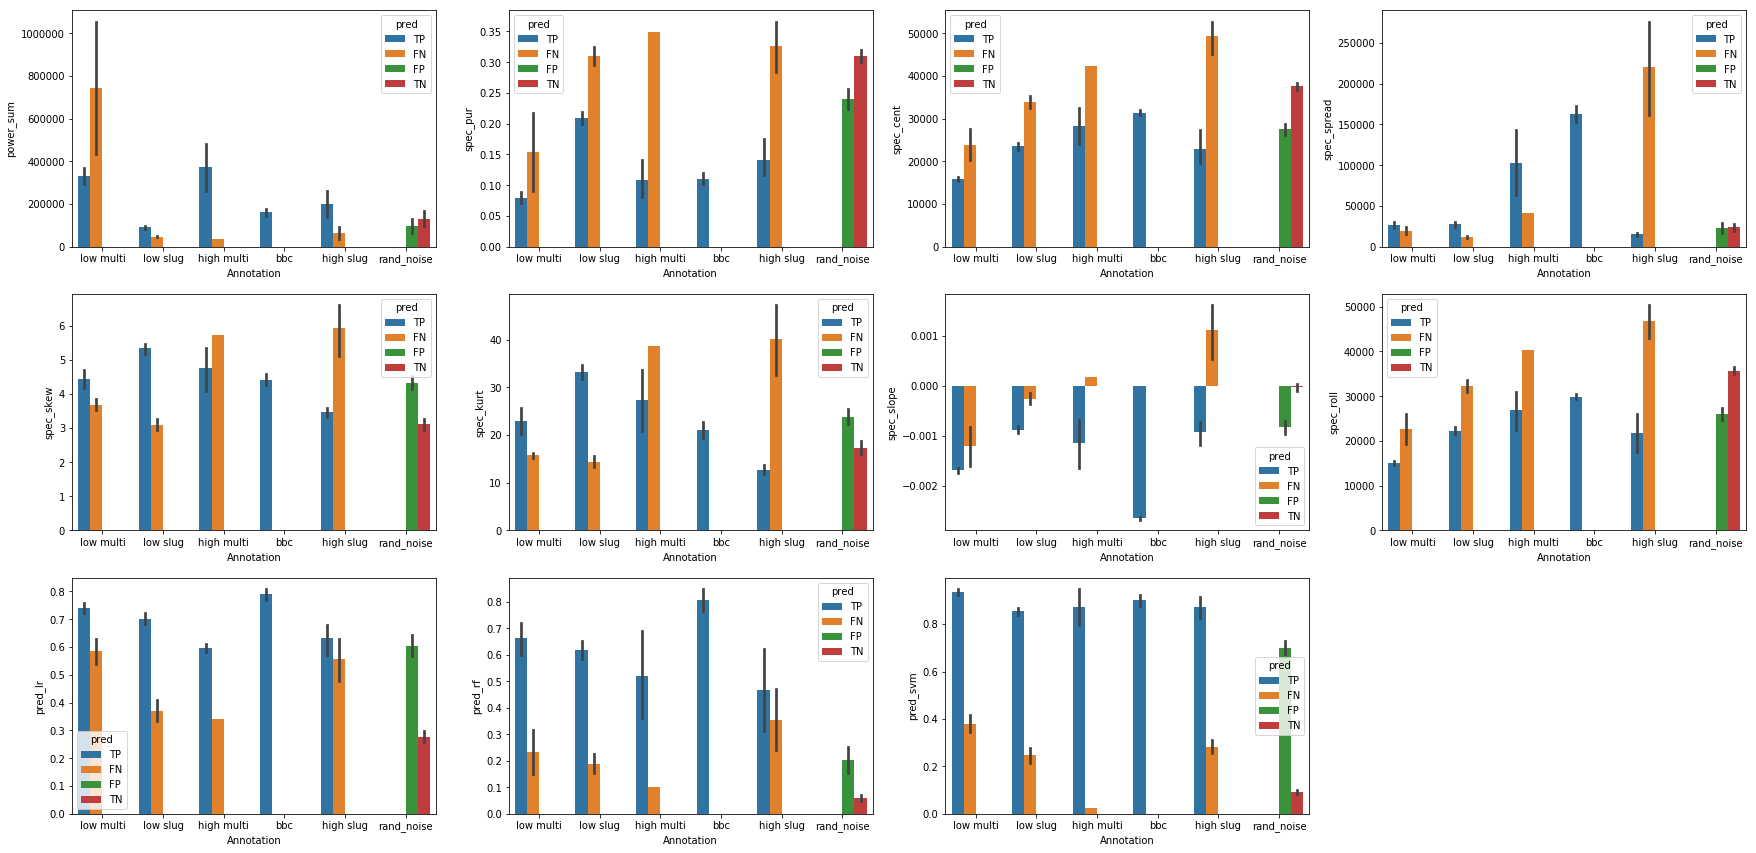

In [31]:
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_lr', 'pred_rf',
       'pred_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_orig_upsamples)
    i = i + 1

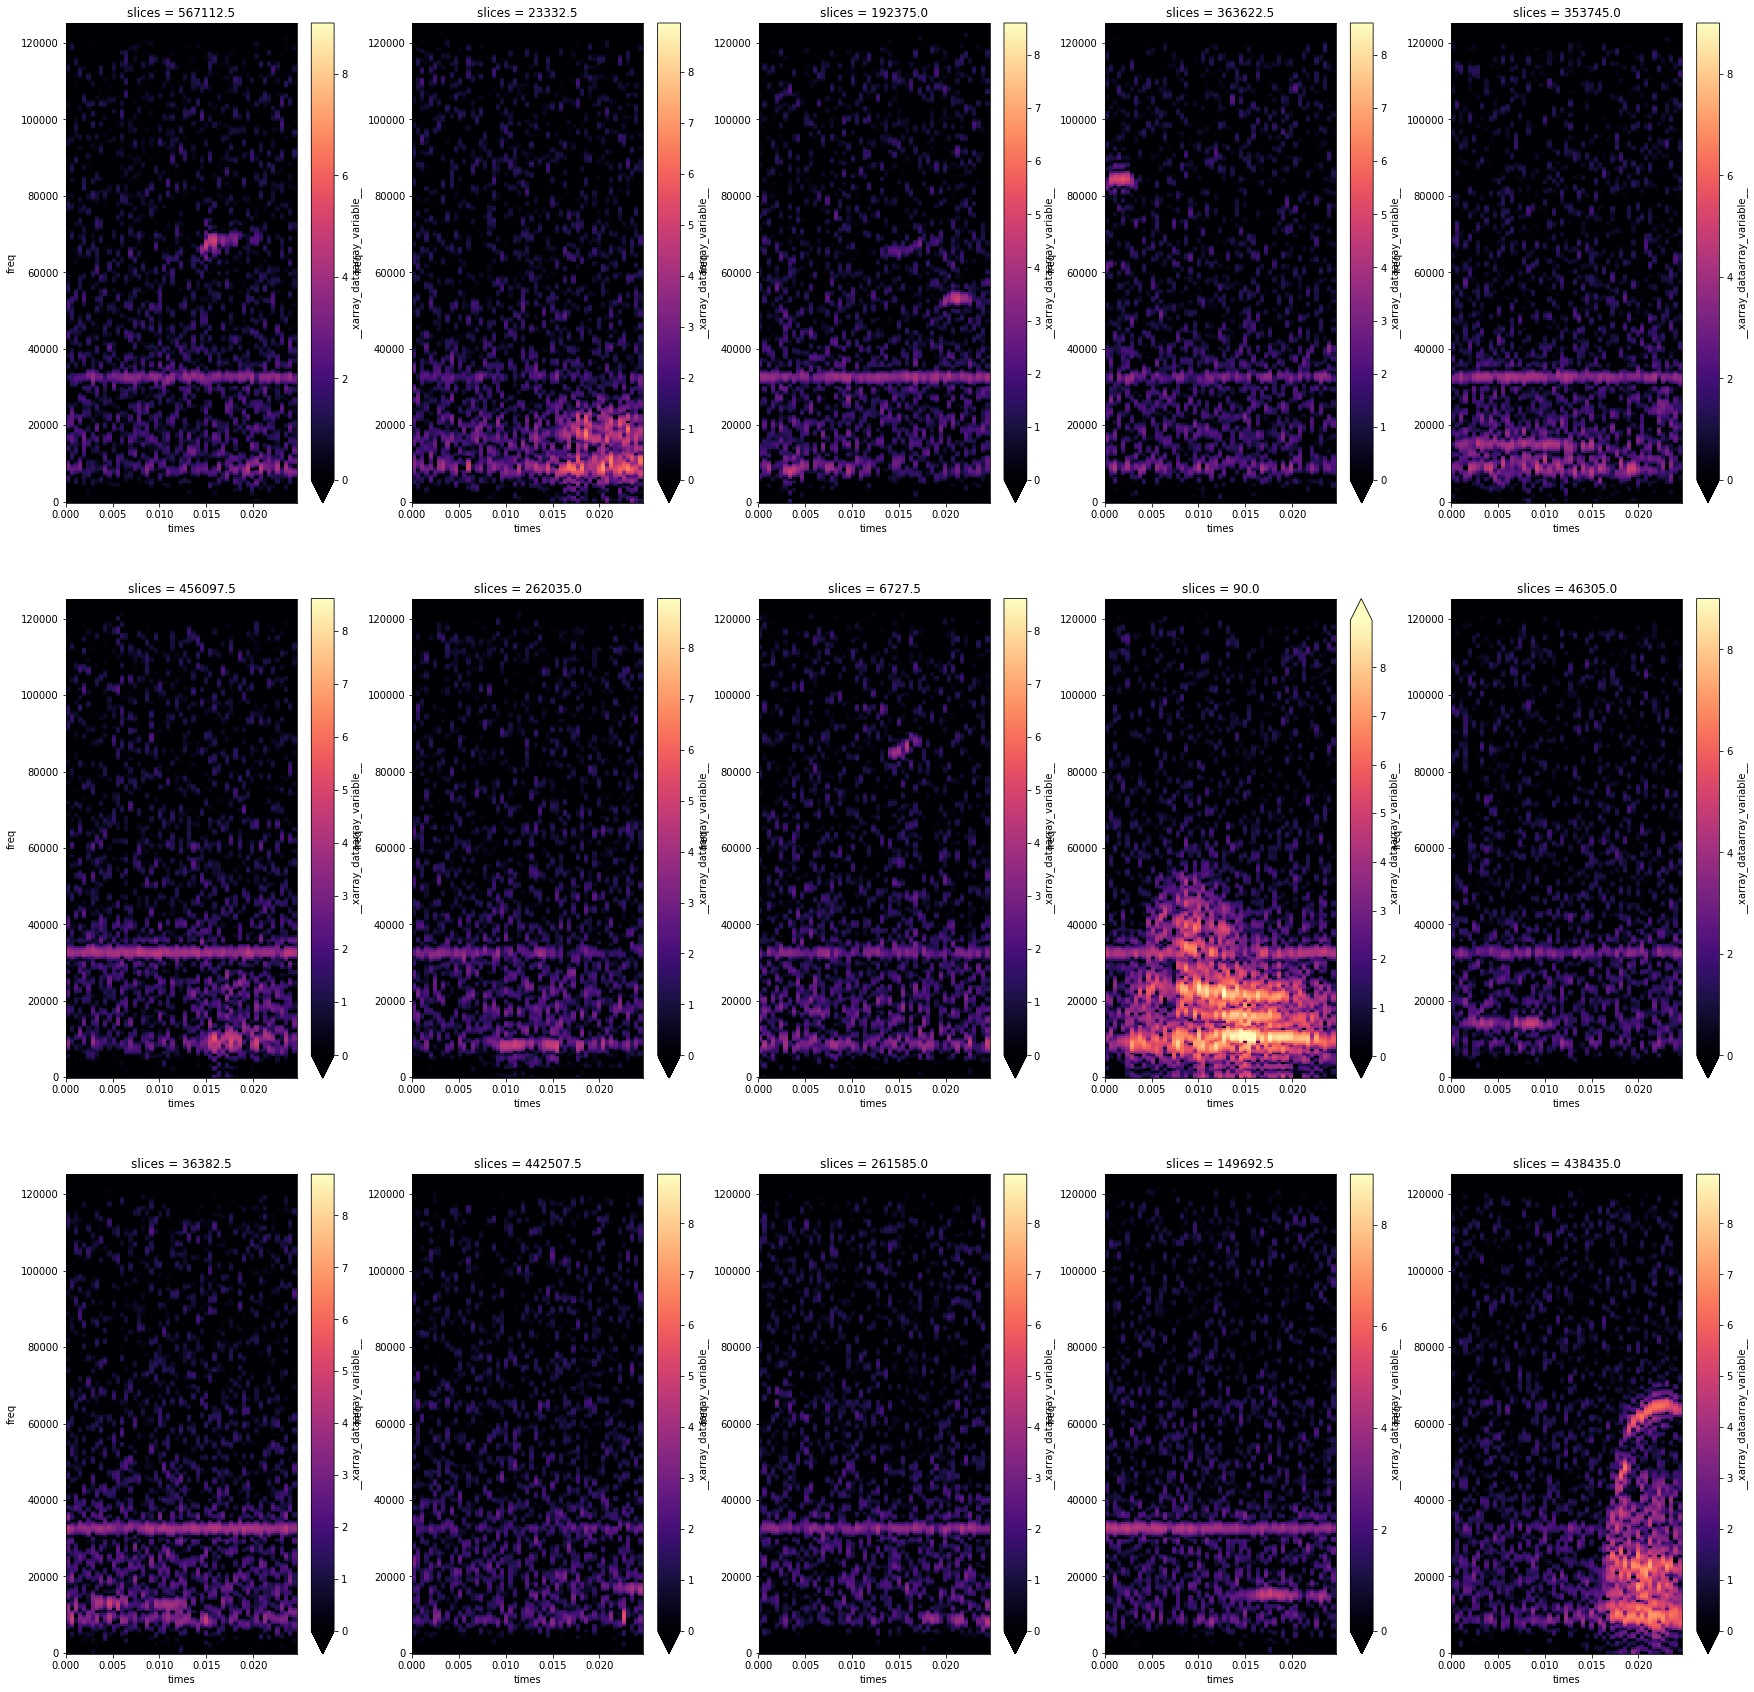

In [57]:
false_neg_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FN'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['Animal']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(3, 5, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

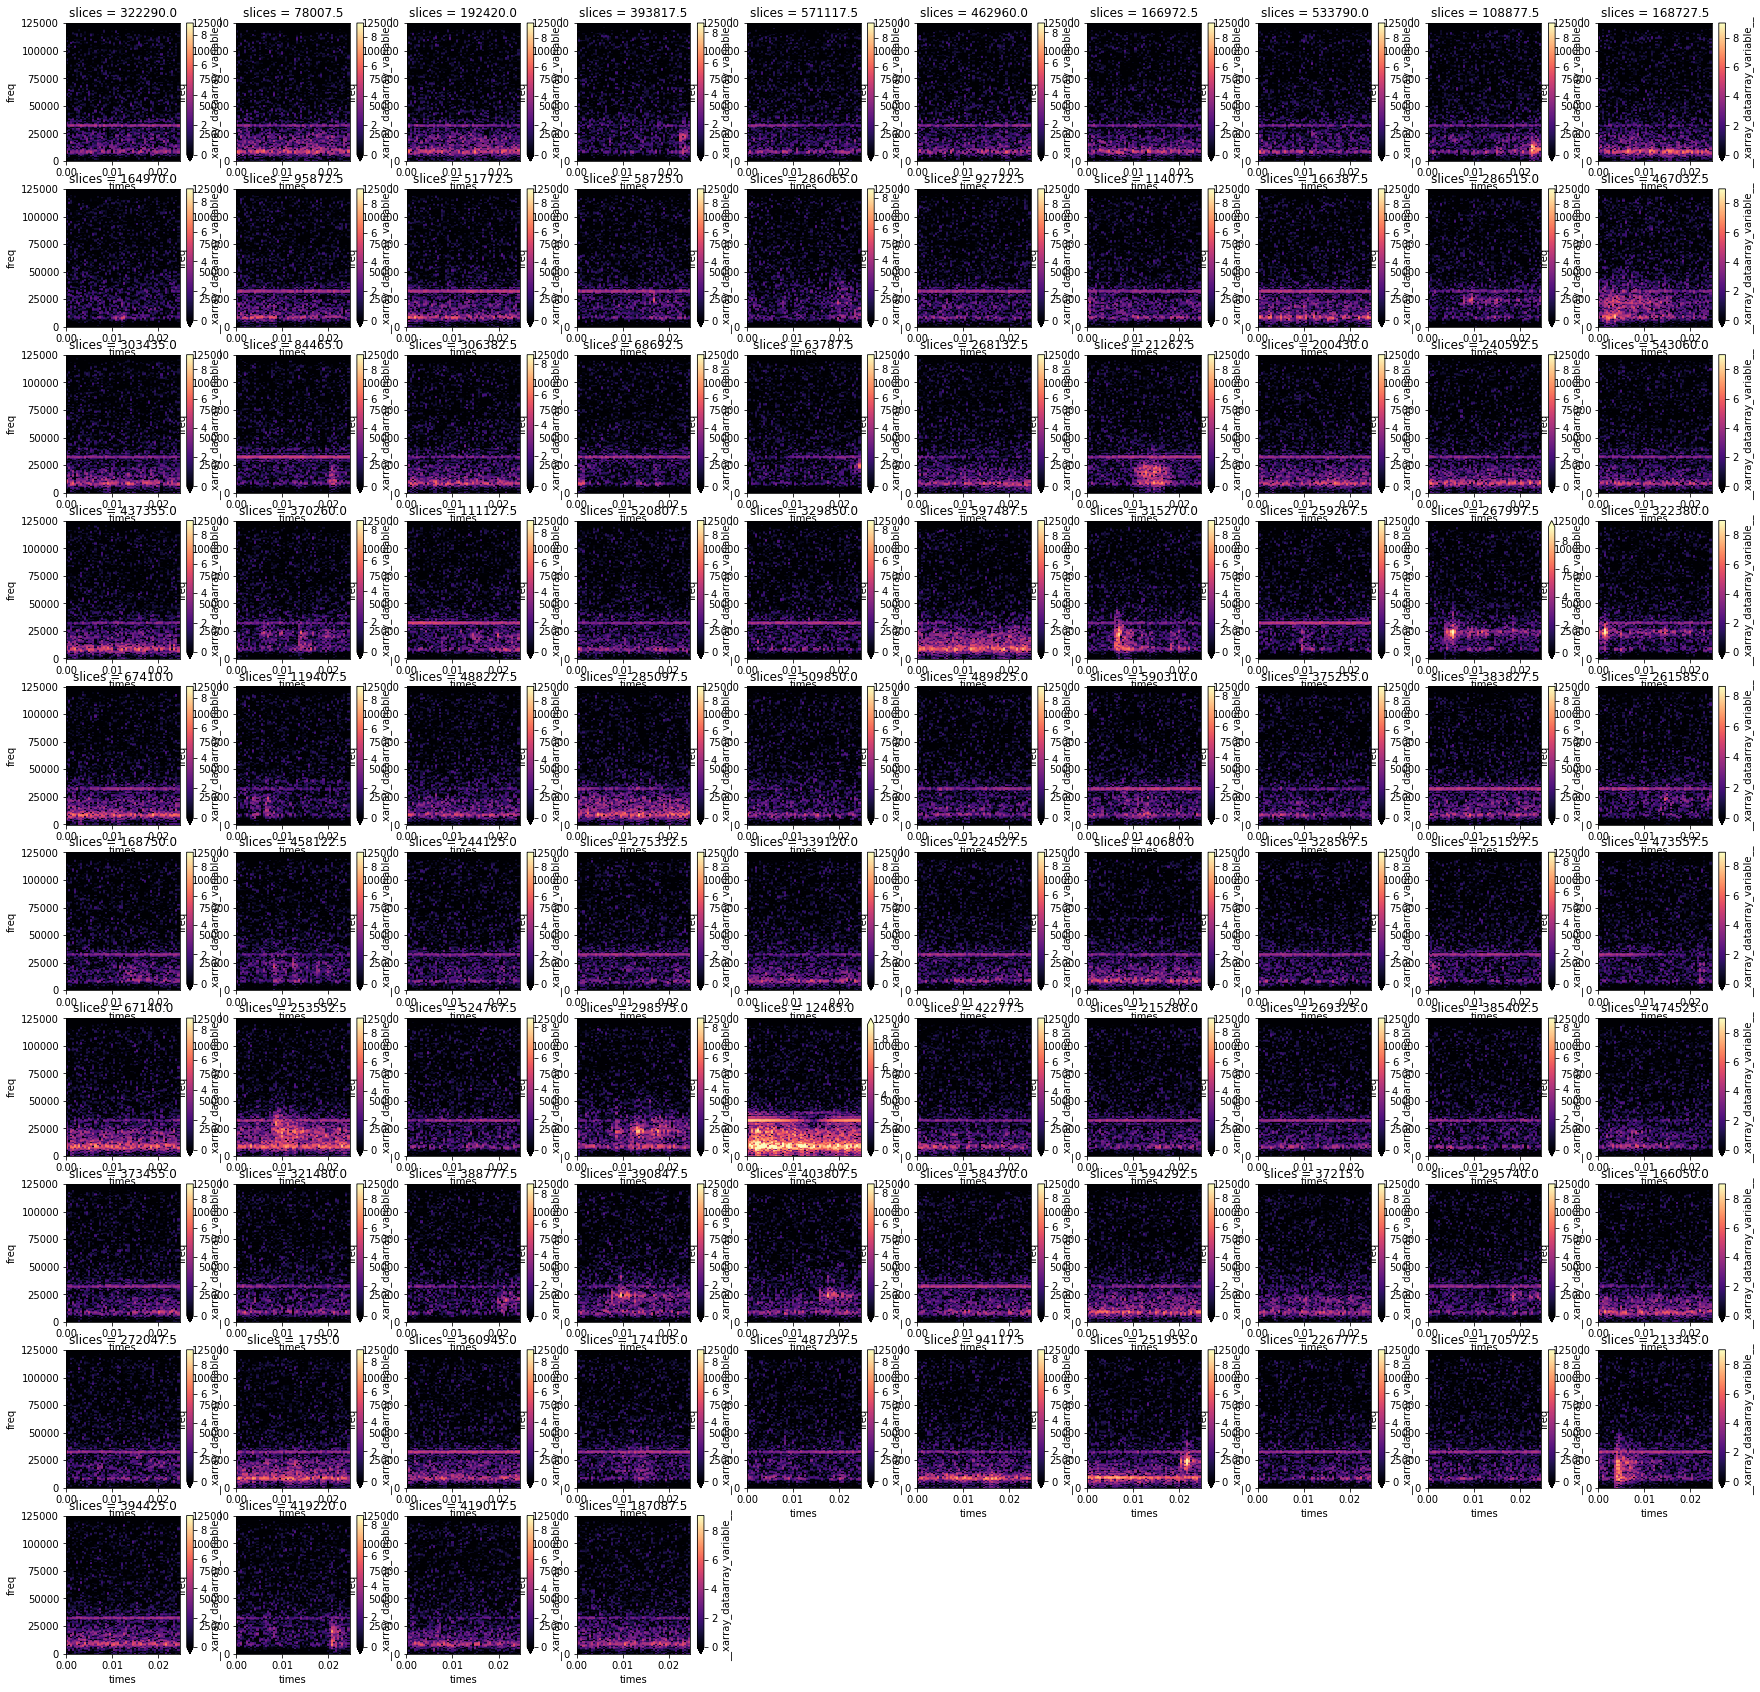

In [62]:
false_pos_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FP'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['Animal']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(10, 10, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1